<a href="https://colab.research.google.com/github/MuhammadShavaiz/AI_learning/blob/main/Introduction_to_Basic_RNNs_for_NLP_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Causal Sequence Modeling with Basic RNN**

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch 1/10, Loss: 1.9383
Epoch 2/10, Loss: 0.2568
Epoch 3/10, Loss: 0.1587
Epoch 4/10, Loss: 0.1318
Epoch 5/10, Loss: 0.1176
Epoch 6/10, Loss: 0.1083
Epoch 7/10, Loss: 0.1016
Epoch 8/10, Loss: 0.0966
Epoch 9/10, Loss: 0.0927
Epoch 10/10, Loss: 0.0895
Test Loss: 13.4479, Test Accuracy: 0.2055


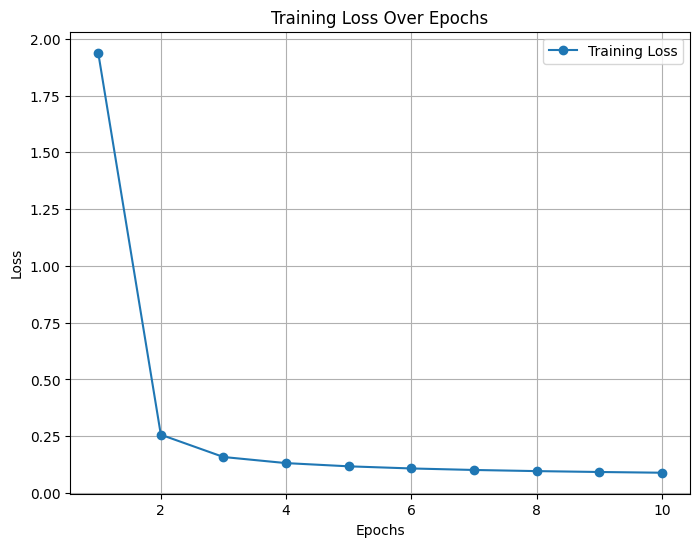

In [5]:
import torch
import nltk
nltk.download('punkt_tab')
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from collections import Counter
import random
import matplotlib.pyplot as plt

# Configuration
train_file = "train.txt"  # Path to the training text file
test_file = "test.txt"    # Path to the testing text file
percentage = 0.05  # Percentage of the file to use
block_size = 128  # Sequence length
batch_size = 32
embed_dim = 128
hidden_dim = 256
epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Read and Tokenize Data
def read_and_tokenize(file_path, percentage):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    num_lines = int(len(lines) * percentage)
    selected_lines = lines[:num_lines]
    text = " ".join(selected_lines)
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    return tokens

# Load datasets
train_tokens = read_and_tokenize(train_file, percentage)
test_tokens = read_and_tokenize(test_file, percentage)

# 2. Create Vocabulary
def build_vocab(tokens):
    freq = Counter(tokens)
    vocab = {word: idx for idx, (word, _) in enumerate(freq.items(), start=2)}
    vocab["<PAD>"] = 0  # Padding token
    vocab["<UNK>"] = 1  # Unknown token
    return vocab, {idx: word for word, idx in vocab.items()}

vocab, idx_to_word = build_vocab(train_tokens)
vocab_size = len(vocab)

# Convert tokens to indices
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

train_indices = tokens_to_indices(train_tokens, vocab)
test_indices = tokens_to_indices(test_tokens, vocab)

# 3. Create Dataset
class SequenceDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        inputs = torch.tensor(self.data[idx : idx + self.block_size])
        targets = torch.tensor(self.data[idx + 1 : idx + 1 + self.block_size])
        return inputs, targets

train_dataset = SequenceDataset(train_indices, block_size)
test_dataset = SequenceDataset(test_indices, block_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 4. Define Model
class CausalRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CausalRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        logits = self.fc(output)
        return logits, hidden

model = CausalRNN(vocab_size, embed_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training function with logging
def train_model_with_logging(model, dataloader, criterion, optimizer, epochs):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            logits, _ = model(inputs)

            logits = logits.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(logits, targets)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    return train_losses

# Evaluation function with accuracy
def evaluate_model_with_accuracy(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits, _ = model(inputs)

            logits = logits.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(logits, targets)
            total_loss += loss.item()

            # Accuracy computation
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == targets).sum().item()
            total_predictions += targets.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_predictions
    return avg_loss, accuracy
# Train the model
train_losses = train_model_with_logging(model, train_loader, criterion, optimizer, epochs)

# Evaluate the model
test_loss, test_accuracy = evaluate_model_with_accuracy(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()



##  **Masked Sequence Modeling with LSTM and GRU**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import random
import gc

# Memory management
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Data processing
def build_vocabulary(dataset, min_freq=5, max_vocab_size=30000):
    counter = Counter()
    # Only use a portion of the dataset for vocabulary building
    for example in dataset["train"][:50000]["text"]:
        counter.update(example.split())

    vocab = {
        "<pad>": 0,
        "<unk>": 1,
        "<mask>": 2,
        "<sos>": 3,
    }

    # Add most common words up to max_vocab_size
    word_idx = len(vocab)
    for word, count in counter.most_common(max_vocab_size - len(vocab)):
        if count >= min_freq:
            vocab[word] = word_idx
            word_idx += 1

    return vocab

class IMDbMaskedDataset(Dataset):
    def __init__(self, dataset, vocab, max_length=256, mask_prob=0.15):  # Reduced max_length
        self.dataset = dataset
        self.vocab = vocab
        self.max_length = max_length
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]["text"]
        tokens = text.split()[:self.max_length]

        token_ids = []
        for token in tokens:
            if token in self.vocab:
                token_ids.append(self.vocab[token])
            else:
                token_ids.append(self.vocab["<unk>"])

        input_ids = []
        target_ids = token_ids.copy()

        for token_id in token_ids:
            if random.random() < self.mask_prob:
                input_ids.append(self.vocab["<mask>"])
            else:
                input_ids.append(token_id)

        return torch.tensor(input_ids), torch.tensor(target_ids)

In [23]:
# Modified models with smaller dimensions
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, _ = self.lstm(embedded)
        return self.fc(output)

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, _ = self.gru(embedded)
        return self.fc(output)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Add gradient clipping
    max_grad_norm = 1.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_inputs, batch_targets in train_bar:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            mask_positions = (batch_inputs == vocab["<mask>"]).float()

            outputs = model(batch_inputs)

            loss = criterion(outputs.view(-1, outputs.size(-1)), batch_targets.view(-1))
            loss = (loss.view(batch_inputs.size()) * mask_positions).sum() / (mask_positions.sum() + 1e-8)

            optimizer.zero_grad()
            loss.backward()

            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            predictions = outputs.argmax(dim=-1)
            correct = (predictions == batch_targets) & (batch_inputs == vocab["<mask>"])
            total_train_correct += correct.sum().item()
            total_train_tokens += mask_positions.sum().item()

            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})

            # Clear some memory
            del outputs, loss, predictions, correct
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / (total_train_tokens + 1e-8)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch_inputs, batch_targets in val_bar:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)

                mask_positions = (batch_inputs == vocab["<mask>"]).float()
                outputs = model(batch_inputs)

                loss = criterion(outputs.view(-1, outputs.size(-1)), batch_targets.view(-1))
                loss = (loss.view(batch_inputs.size()) * mask_positions).sum() / (mask_positions.sum() + 1e-8)

                predictions = outputs.argmax(dim=-1)
                correct = (predictions == batch_targets) & (batch_inputs == vocab["<mask>"])
                total_val_correct += correct.sum().item()
                total_val_tokens += mask_positions.sum().item()

                total_val_loss += loss.item()
                val_bar.set_postfix({'loss': loss.item()})

                # Clear some memory
                del outputs, loss, predictions, correct
                torch.cuda.empty_cache()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_val_correct / (total_val_tokens + 1e-8)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Clear memory between epochs
        clear_gpu_memory()

    return train_losses, val_losses, train_accuracies, val_accuracies

Loading IMDb dataset...
Building vocabulary...
Vocabulary size: 30000
Using device: cuda

Training LSTM model...


Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.96it/s, loss=6.68]


Epoch 1/10:
Train Loss: 6.9233, Train Accuracy: 0.0814
Val Loss: 6.4517, Val Accuracy: 0.1098


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.72it/s, loss=6.19]


Epoch 2/10:
Train Loss: 6.3437, Train Accuracy: 0.1173
Val Loss: 6.0902, Val Accuracy: 0.1304


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.22it/s, loss=6.26]


Epoch 3/10:
Train Loss: 6.1119, Train Accuracy: 0.1292
Val Loss: 5.9075, Val Accuracy: 0.1390


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.39it/s, loss=5.51]


Epoch 4/10:
Train Loss: 5.9711, Train Accuracy: 0.1367
Val Loss: 5.8109, Val Accuracy: 0.1469


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.69it/s, loss=5.68]


Epoch 5/10:
Train Loss: 5.8849, Train Accuracy: 0.1414
Val Loss: 5.7375, Val Accuracy: 0.1512


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.80it/s, loss=5.54]


Epoch 6/10:
Train Loss: 5.8062, Train Accuracy: 0.1453
Val Loss: 5.6752, Val Accuracy: 0.1539


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.77it/s, loss=5.7]


Epoch 7/10:
Train Loss: 5.7380, Train Accuracy: 0.1489
Val Loss: 5.6237, Val Accuracy: 0.1573


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 24.00it/s, loss=5.74]


Epoch 8/10:
Train Loss: 5.6936, Train Accuracy: 0.1518
Val Loss: 5.5853, Val Accuracy: 0.1600


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.33it/s, loss=5.68]


Epoch 9/10:
Train Loss: 5.6389, Train Accuracy: 0.1546
Val Loss: 5.5418, Val Accuracy: 0.1625


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.31it/s, loss=5.34]


Epoch 10/10:
Train Loss: 5.6066, Train Accuracy: 0.1564
Val Loss: 5.5238, Val Accuracy: 0.1640

Training GRU model...


Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.70it/s, loss=5.99]


Epoch 1/10:
Train Loss: 6.9200, Train Accuracy: 0.0847
Val Loss: 6.2701, Val Accuracy: 0.1187


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.55it/s, loss=5.94]


Epoch 2/10:
Train Loss: 6.2236, Train Accuracy: 0.1228
Val Loss: 5.9528, Val Accuracy: 0.1364


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.57it/s, loss=5.81]


Epoch 3/10:
Train Loss: 6.0243, Train Accuracy: 0.1337
Val Loss: 5.8228, Val Accuracy: 0.1455


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.94it/s, loss=5.85]


Epoch 4/10:
Train Loss: 5.9096, Train Accuracy: 0.1393
Val Loss: 5.7307, Val Accuracy: 0.1490


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 24.00it/s, loss=5.8]


Epoch 5/10:
Train Loss: 5.8244, Train Accuracy: 0.1439
Val Loss: 5.6777, Val Accuracy: 0.1527


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.82it/s, loss=5.92]


Epoch 6/10:
Train Loss: 5.7528, Train Accuracy: 0.1475
Val Loss: 5.6097, Val Accuracy: 0.1575


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.08it/s, loss=5.42]


Epoch 7/10:
Train Loss: 5.7046, Train Accuracy: 0.1497
Val Loss: 5.5901, Val Accuracy: 0.1582


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:12<00:00, 24.51it/s, loss=5.46]


Epoch 8/10:
Train Loss: 5.6617, Train Accuracy: 0.1527
Val Loss: 5.5605, Val Accuracy: 0.1618


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.56it/s, loss=5.57]


Epoch 9/10:
Train Loss: 5.6155, Train Accuracy: 0.1550
Val Loss: 5.5364, Val Accuracy: 0.1647


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:13<00:00, 23.61it/s, loss=5.72]


Epoch 10/10:
Train Loss: 5.5826, Train Accuracy: 0.1562
Val Loss: 5.5181, Val Accuracy: 0.1639

Plotting metrics...


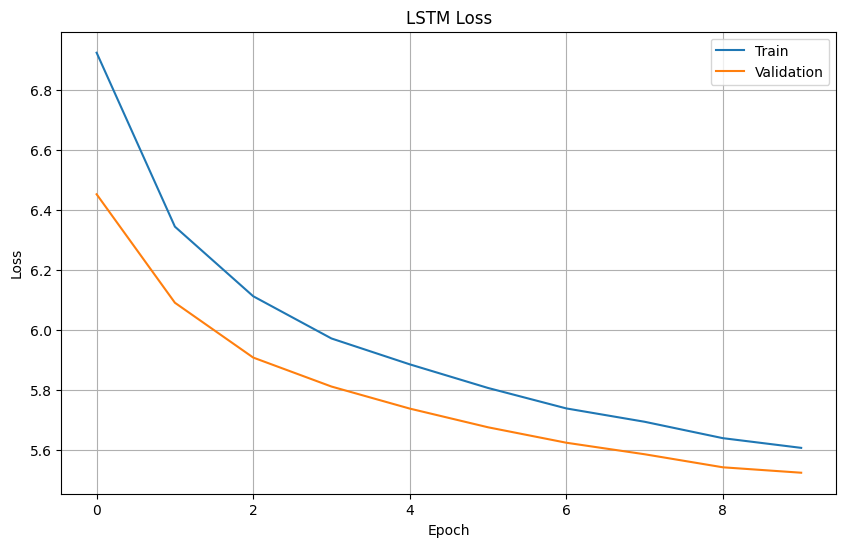

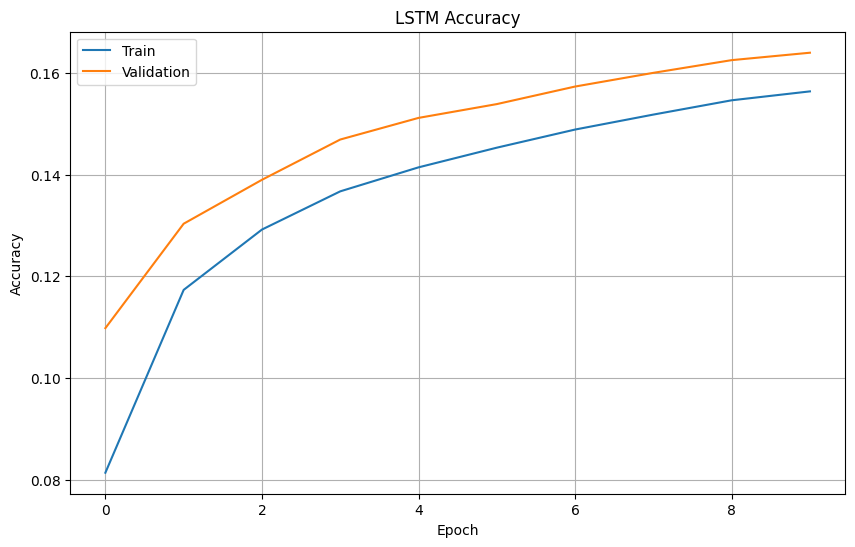

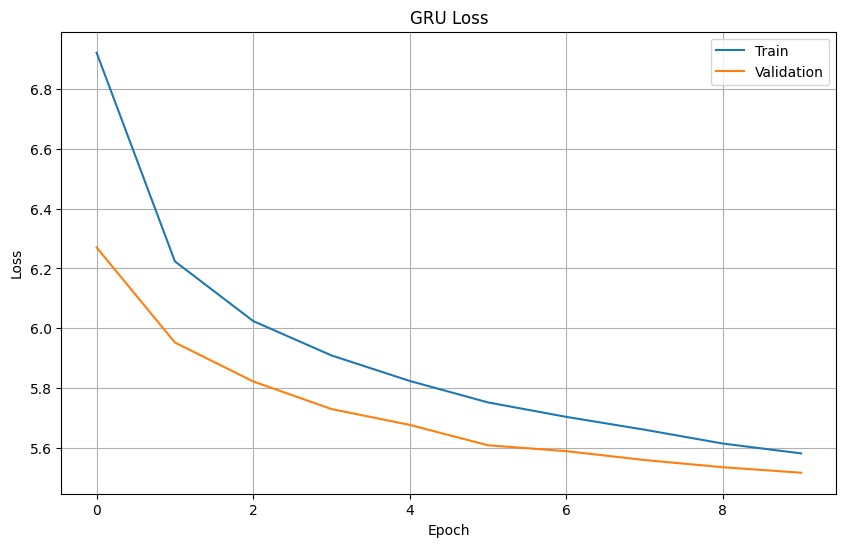

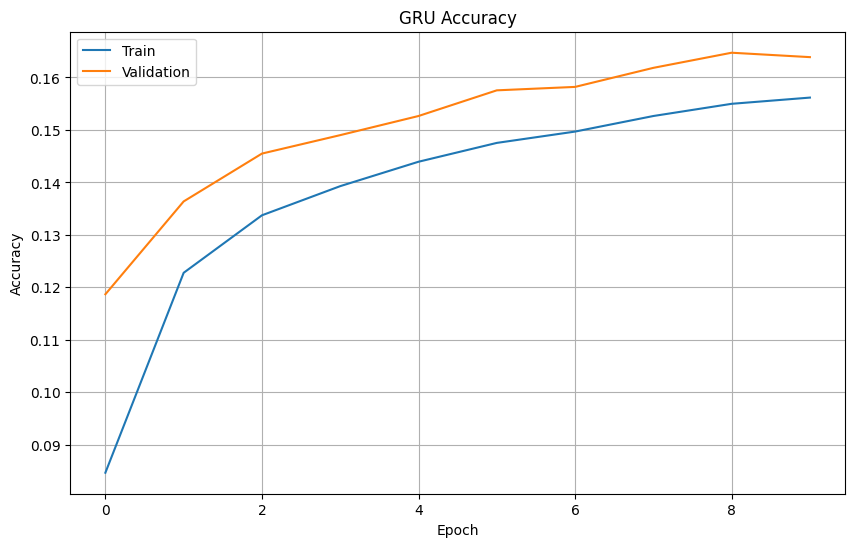

In [25]:
def plot_metrics(train_metrics, val_metrics, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label='Train')
    plt.plot(val_metrics, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Set random seeds
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    # Load dataset
    print("Loading IMDb dataset...")
    dataset = load_dataset("imdb")

    # Build vocabulary
    print("Building vocabulary...")
    vocab = build_vocabulary(dataset, max_vocab_size=30000)
    print(f"Vocabulary size: {len(vocab)}")

    # Use only a portion of the dataset
    train_size = 25000  # Using 25k samples instead of full dataset
    val_size = 5000

    train_dataset = IMDbMaskedDataset(
        Subset(dataset["train"], range(train_size)),
        vocab
    )
    val_dataset = IMDbMaskedDataset(
        Subset(dataset["test"], range(val_size)),
        vocab
    )

    # Smaller batch size and fewer workers
    batch_size = 16
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Training parameters
    num_epochs = 10
    learning_rate = 0.001

    # Clear GPU memory before starting
    clear_gpu_memory()

    # Train LSTM
    print("\nTraining LSTM model...")
    lstm_model = LSTMModel(len(vocab)).to(device)
    lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"], reduction='none')

    lstm_metrics = train_model(
        lstm_model, train_loader, val_loader,
        criterion, lstm_optimizer, device, num_epochs
    )

    # Clear memory before training GRU
    clear_gpu_memory()

    # Train GRU
    print("\nTraining GRU model...")
    gru_model = GRUModel(len(vocab)).to(device)
    gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

    gru_metrics = train_model(
        gru_model, train_loader, val_loader,
        criterion, gru_optimizer, device, num_epochs
    )

    # Plot metrics
    print("\nPlotting metrics...")
    plot_metrics(lstm_metrics[0], lstm_metrics[1], 'LSTM Loss', 'Loss')
    plot_metrics(lstm_metrics[2], lstm_metrics[3], 'LSTM Accuracy', 'Accuracy')
    plot_metrics(gru_metrics[0], gru_metrics[1], 'GRU Loss', 'Loss')
    plot_metrics(gru_metrics[2], gru_metrics[3], 'GRU Accuracy', 'Accuracy')